In [133]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
style.use('ggplot')

num_epochs = 100
input_length = 10
batch_size = 16

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

start = datetime(2011, 1, 1)
end = datetime(2021, 1, 1)

df = web.DataReader('TSLA', 'yahoo', start, end).reset_index(level=0)
'''
df.to_csv('tsla.csv')

df = pd.read_csv('tsla.csv', index_col=0).reset_index()
'''
df.head()


,Date,High,Low,Open,Close,Volume,Adj Close
0,2011-01-03,5.400,5.180,5.368,5.324,6415000.0,5.324
1,2011-01-04,5.390,5.204,5.332,5.334,5937000.0,5.334
2,2011-01-05,5.380,5.238,5.296,5.366,7233500.0,5.366
3,2011-01-06,5.600,5.362,5.366,5.576,10306000.0,5.576
4,2011-01-07,5.716,5.580,5.600,5.648,11239500.0,5.648


In [110]:
df = pd.DataFrame(df[['Date','Adj Close']])
df['Date']=pd.to_datetime(df['Date'])
df.head()

,Date,Adj Close
0,2011-01-03,5.324
1,2011-01-04,5.334
2,2011-01-05,5.366
3,2011-01-06,5.576
4,2011-01-07,5.648


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2517 non-null   datetime64[ns]
 1   Adj Close  2517 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.5 KB


In [112]:
df.set_index('Date', inplace=True)

In [113]:
df['2015'].head()

,Adj Close
Date,
2015-01-02,43.862000
2015-01-05,42.018002
2015-01-06,42.256001
2015-01-07,42.189999
2015-01-08,42.124001


In [114]:
date_range = df.index.max()-df.index.min()
print(date_range)

3650 days 00:00:00


In [115]:
new_index = pd.date_range(df.index.min(),df.index.max())
df = df.reindex(new_index)

In [116]:
df['Adj Close'].value_counts(dropna=False)

NaN          1134
5.484000        4
42.018002       3
5.424000        3
6.492000        3
             ... 
56.366001       1
48.292000       1
42.888000       1
39.209999       1
49.548000       1
Name: Adj Close, Length: 2354, dtype: int64

In [117]:
df['Adj Close'].interpolate(method='linear', inplace=True)

In [118]:
df['Adj Close'].value_counts(dropna=False)


5.484000     4
5.634000     3
6.492000     3
5.320000     3
42.018002    3
            ..
45.557999    1
4.748500     1
34.335499    1
25.804000    1
6.750000     1
Name: Adj Close, Length: 3471, dtype: int64

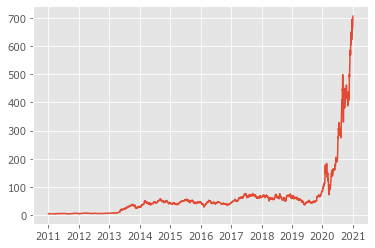

In [119]:
plt.plot(df)

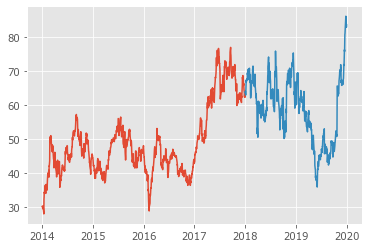

In [120]:
train_data = df['2014':'2017']
test_data = df['2018':'2019']

plt.plot(train_data)
plt.plot(test_data)

In [121]:
scaler = MinMaxScaler(feature_range=(-1,1))
train_data_scaled = scaler.fit_transform(train_data)

In [122]:
train_data_scaled

array([[-0.91105591],
       [-0.91239923],
       [-0.91679555],
       ...,
       [ 0.4003908 ],
       [ 0.41907519],
       [ 0.43775957]])

In [123]:
train_data_scaled = torch.FloatTensor(train_data_scaled).view(-1).to(device)

In [124]:
train_data_scaled

tensor([-0.9111, -0.9124, -0.9168,  ...,  0.4004,  0.4191,  0.4378])

In [125]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [126]:
train_data=pd.DataFrame(train_data)

In [127]:
from torch.utils.data import Dataset, DataLoader

class SingleTimeSeriesDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, dataframe, input_length):
        self.whole_dataframe = dataframe
        for lag in range(1, input_length + 1):
            self.whole_dataframe['lag_' + str(lag)] = self.whole_dataframe[self.whole_dataframe.columns[0]].shift(lag)
        self.whole_dataframe.dropna(inplace=True)
        

    def __len__(self):
        return len(self.whole_dataframe)

    def __getitem__(self, idx):
        return torch.Tensor(np.array(self.whole_dataframe.iloc[idx,1:]).reshape(1,-1)),torch.Tensor(np.array(self.whole_dataframe.iloc[idx,0]).reshape(1,-1))

In [128]:
dataset = SingleTimeSeriesDataset(train_data,input_length)

In [129]:
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

In [130]:
# for i_batch, batch in enumerate(dataloader):
    # print(i_batch, batch)

In [131]:
model = LSTM(input_size=input_length)
model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(10, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [134]:

training_losses=[]
for epoch in range(num_epochs):
    for i_batch, (x, y) in enumerate(dataloader):
        model.train()
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))
        prediction = model(x)
        loss = loss_function(prediction, y)
        training_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        print('Epoch : ',epoch+1, "for Batch:",i_batch, '\t', 'loss :',loss.item())



54688
Epoch :  96 for Batch: 80 	 loss : 53.203128814697266
Epoch :  96 for Batch: 81 	 loss : 97.29737854003906
Epoch :  96 for Batch: 82 	 loss : 146.1568603515625
Epoch :  96 for Batch: 83 	 loss : 77.9465103149414
Epoch :  96 for Batch: 84 	 loss : 94.27851867675781
Epoch :  96 for Batch: 85 	 loss : 69.96851348876953
Epoch :  96 for Batch: 86 	 loss : 59.41233825683594
Epoch :  96 for Batch: 87 	 loss : 53.74589920043945
Epoch :  96 for Batch: 88 	 loss : 24.83647346496582
Epoch :  96 for Batch: 89 	 loss : 92.51013946533203
Epoch :  96 for Batch: 90 	 loss : 39.89796447753906
Epoch :  97 for Batch: 0 	 loss : 143.25196838378906
Epoch :  97 for Batch: 1 	 loss : 107.15638732910156
Epoch :  97 for Batch: 2 	 loss : 130.0963897705078
Epoch :  97 for Batch: 3 	 loss : 61.75593566894531
Epoch :  97 for Batch: 4 	 loss : 152.8906707763672
Epoch :  97 for Batch: 5 	 loss : 38.056640625
Epoch :  97 for Batch: 6 	 loss : 87.43818664550781
Epoch :  97 for Batch: 7 	 loss : 68.4211883544921

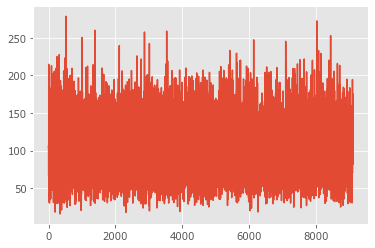

In [135]:
import matplotlib.pyplot as plt
plt.plot(training_losses)

In [144]:
model.eval()
model(np.array([[10 for i in range(10)]]))

TypeError: view() takes at most 2 arguments (3 given)